In [8]:
import gc
import math
import sys
sys.path.append("../../pytorch-forecasting")

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook

from utilities import *
import pandas as pd
from tqdm import tqdm

from data_factory.prepared_data import TimeSeriesData, PreparedData
import math
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

sns.set_style("whitegrid")
tqdm.pandas()

import matplotlib.pyplot as plt

pl.seed_everything(42)

Global seed set to 42


42

In [9]:
config = load_config("../config/config.yml")
assert config['model'] == 'temporal_fusion_transformer', 'Invalid model in file configuration for this script'
model = config['model']
model_config = config[model]

data_ts: TimeSeriesData = TimeSeriesData.from_file('../data/save/timeseries_data.pkl')
data: PreparedData = PreparedData.from_file('../data/save/augmented_data.pkl')

max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

### Results

#### load model

In [10]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=-1)

model = TemporalFusionTransformer.load_from_checkpoint('./lightning_logs/lightning_logs/version_57/checkpoints/epoch=1-step=59620.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


#### Recreate dataloaders

In [11]:
# Training
train_dl = data_ts.train.to_dataloader(train=True, batch_size=batch_size, num_workers=12)


# Validation
val_dl = data_ts.val.to_dataloader(train=False, batch_size=batch_size, num_workers=12, shuffle=False)


# Testing
test_dl = data_ts.test.to_dataloader(
    batch_size=data_ts.test_set_size,
    num_workers=12,
    shuffle=False
)

#### Results

In [12]:
import numpy as np

y_true = torch.cat([y for _, (y, _) in tqdm(iter(test_dl))])
y_hat = trainer.predict(model, (X for X, (y, _) in test_dl))

y_hat_np = np.array([i.prediction.numpy() for i in y_hat]).reshape(-1, max_prediction_length, model_config['output_size'])
y_true_np = y_true.cpu().detach().numpy()

y_hat_np.shape, y_true_np.shape

100%|██████████| 2000/2000 [00:13<00:00, 152.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


((112000, 5, 7), (112000, 5))

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/py

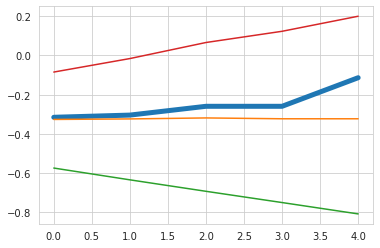

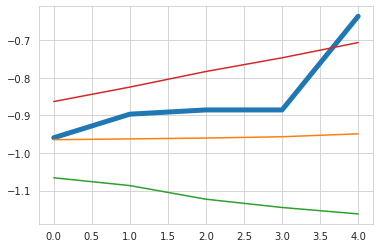

In [13]:
for id in range(100, 200, 50):
    plt.plot(y_true_np[id], linewidth=5)
    plt.plot(y_hat_np[id, :, 3])
    plt.plot(y_hat_np[id, :, 0])
    plt.plot(y_hat_np[id, :, 6])
    plt.show()

In [14]:
y_true_unscaled = y_true_np.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length).copy()
y_hat_unscaled = y_hat_np.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length * 7).copy()

for i, scaler in enumerate(data.scalers['Close']):
    y_true_unscaled[i] = scaler.inverse_transform(y_true_unscaled[i])
    y_hat_unscaled[i] = scaler.inverse_transform(y_hat_unscaled[i])

y_true_unscaled = y_true_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'])
y_hat_unscaled = y_hat_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'], model_config['output_size'])

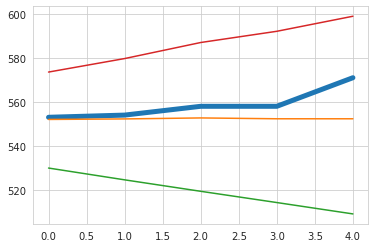

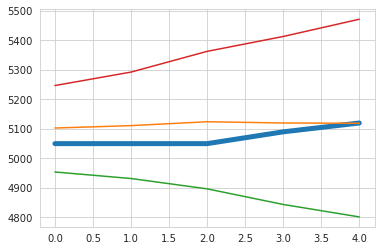

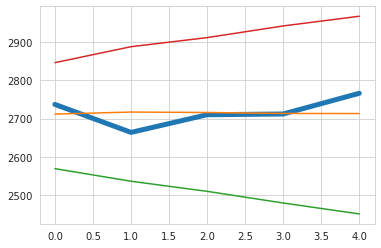

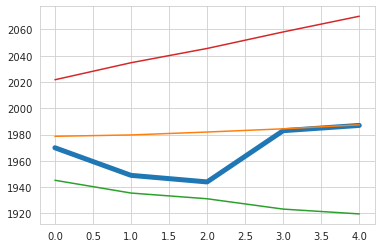

In [15]:
for id in range(100, 2000, 500):
    plt.plot(y_true_unscaled[id], linewidth=5)
    plt.plot(y_hat_unscaled[id, :, 3])
    plt.plot(y_hat_unscaled[id, :, 0])
    plt.plot(y_hat_unscaled[id, :, 6])
    plt.show()

In [16]:
mid_value = math.floor(model_config['output_size'] / 2)
mid_value

3

In [17]:
data.test.columns

Index(['Timestamp', 'RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low',
       'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend',
       'SupervisionFlag', 'Target', 'Open_scaled', 'High_scaled', 'Low_scaled',
       'Close_scaled', 'Volume_scaled', 'Timestamp_1', 'is_testing', 'is_val',
       'authentic', 'top_0', 'Close_top_0', 'Close_scaled_top_0',
       'Close_scaled_ewm_200', 'Close_scaled_ewm_100', 'Close_scaled_ewm_50',
       'Close_scaled_ewm_10', 'Close_scaled_diff_d1', 'Close_scaled_diff_d2',
       'Close_scaled_diff_d3', 'Close_scaled_diff_d4', 'Close_scaled_diff_d5',
       'Close_scaled_diff_d10', 'Close_scaled_diff_d30', 'High_scaled_diff_d1',
       'High_scaled_diff_d2', 'High_scaled_diff_d3', 'High_scaled_diff_d4',
       'High_scaled_diff_d5', 'High_scaled_diff_d10', 'High_scaled_diff_d30',
       'Low_scaled_diff_d1', 'Low_scaled_diff_d2', 'Low_scaled_diff_d3',
       'Low_scaled_diff_d4', 'Low_scaled_diff_d5', 'Low_scaled_diff_d10',
       'Low_sca

In [18]:
vt = (data.test.is_testing == True)

data.test.loc[vt, 'close_true'] = y_true_np[:, 0].flatten()
data.test.loc[vt, 'close_pred'] = y_hat_np[:, 0, mid_value].flatten()

data.test.loc[vt, 'close_true_unscaled'] = y_true_unscaled[:, 0].flatten()
data.test.loc[vt, 'close_pred_unscaled'] = y_hat_unscaled[:, 0, mid_value].flatten()

data.test.loc[vt, 'target_true'] = (y_true_np[:, 1] - y_true_np[:, 0]) / y_true_np[:, 0]
data.test.loc[vt, 'target_pred'] = (y_hat_np[:, 1, mid_value] - y_hat_np[:, 0, mid_value]) / y_hat_np[:, 0, mid_value]

for i in range(model_config['output_size']):
    data.test.loc[vt, f'close_pred_unscaled_full_{i}'] = pd.Series(list(y_hat_unscaled[:, :, i]), index=data.test[vt].index)

data.test.loc[vt, 'target_true_unscaled'] = (y_true_unscaled[:, 1] - y_true_unscaled[:, 0]) / y_true_unscaled[:, 0]
data.test.loc[vt, 'target_pred_unscaled'] = (y_hat_unscaled[:, 1, mid_value] - y_hat_unscaled[:, 0, mid_value]) / y_hat_unscaled[:, 0, mid_value]

data.test.loc[vt, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
150,2971.0,3065.0,2981.404053,-0.003263,-0.003263,-0.000532
151,3065.0,3055.0,3087.341064,0.009820,0.009820,-0.000006
152,3055.0,3085.0,3073.919678,0.006483,0.006483,-0.000186
153,3085.0,3105.0,3104.218750,-0.006441,-0.006441,0.000508
154,3105.0,3085.0,3122.682129,-0.008104,-0.008104,0.000502
...,...,...,...,...,...,...
421990,727.0,721.0,735.577026,-0.002774,-0.002774,-0.001016
421991,721.0,719.0,724.568726,0.019471,0.019471,0.001787
421992,719.0,733.0,724.434448,0.001364,0.001364,0.001863
421993,733.0,734.0,739.243530,-0.001362,0.000000,0.002953


In [20]:
data.test.loc[vt, ['authentic', 'Timestamp', 'target_true_unscaled', 'Target', 'target_pred_unscaled']]

,authentic,Timestamp,target_true_unscaled,Target,target_pred_unscaled
150,True,18967,-0.003263,-0.003263,-0.000532
151,True,18968,0.009820,0.009820,-0.000006
152,True,18969,0.006483,0.006483,-0.000186
153,True,18970,-0.006441,-0.006441,0.000508
154,True,18971,-0.008104,-0.008104,0.000502
...,...,...,...,...,...
421990,True,19044,-0.002774,-0.002774,-0.001016
421991,True,19045,0.019471,0.019471,0.001787
421992,True,19047,0.001364,0.001364,0.001863
421993,True,19048,0.000000,-0.001362,0.002953


In [22]:
dir_true = data.test.target_true > 0
dir_pred = data.test.target_pred > 0


In [39]:
max_prediction_length

5

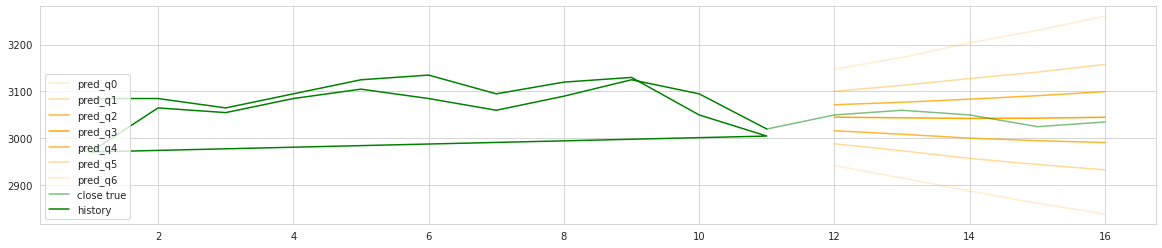

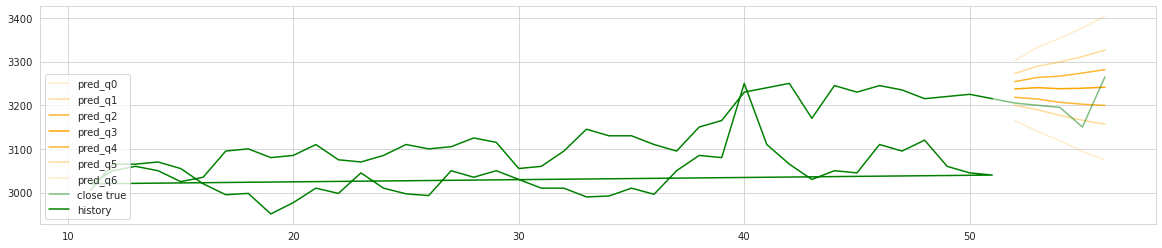

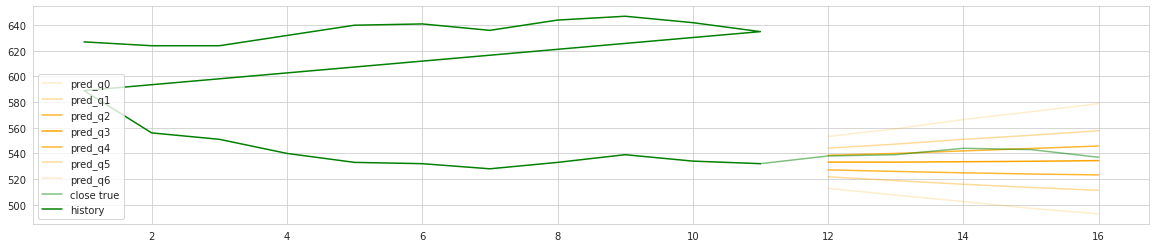

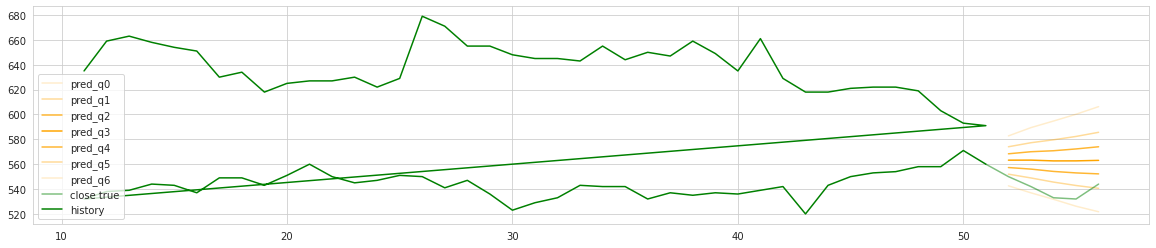

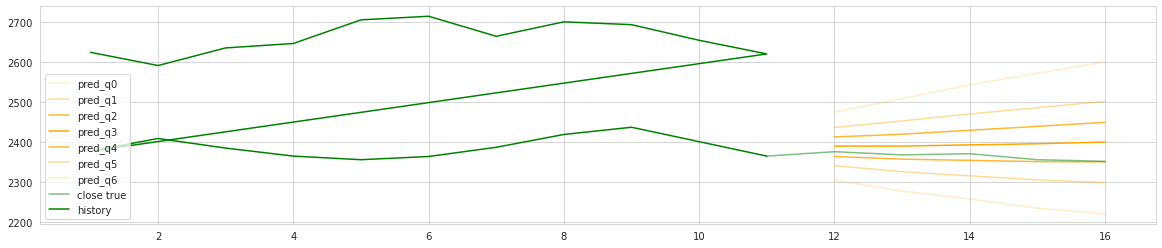

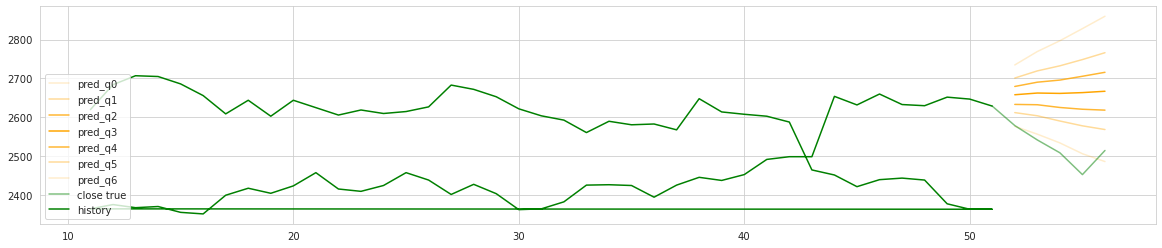

In [52]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

for sc in data.test.SecuritiesCode.unique()[:3]:
    for start_point in [10, 50]:
        df_full = data.test[(data.test.SecuritiesCode == sc)]
        df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]

        df_pred = df_pred[(df_pred.Timestamp_1 >= df_pred.Timestamp_1.min() + start_point) &
                          (df_pred.Timestamp_1 <= df_pred.Timestamp_1.min() + start_point + max_prediction_length)]
        df_full = df_full[(df_full.Timestamp_1 >= df_pred.Timestamp_1.min() - (max_encoder_length - 110))
                          & (df_full.Timestamp_1 <= df_pred.Timestamp_1.min())]

        figure = plt.figure(figsize=(20, 4))

        for i, a in zip(range(model_config['output_size']), [0.2, .4, .8, 1, .8, .4, .2]):
            plt.plot(df_pred.Timestamp_1.iloc[1:], df_pred[f'close_pred_unscaled_full_{i}'].iloc[0], label=f'pred_q{i}', figure=figure, c='orange', alpha=a)

        plt.plot(df_pred.Timestamp_1, df_pred.Close, label='close true', figure=figure, alpha=.5, c='g')
        # plt.plot(df_pred.Date + datetime.timedelta(days=1), df_pred.close_pred_unscaled, label='close_pred_unscaled', figure=figure, alpha=.5)

        # Plot history
        plt.plot(df_full.Timestamp_1, df_full.Close, label='history', figure=figure, c='g')

        plt.legend(loc='lower left')
        plt.show()

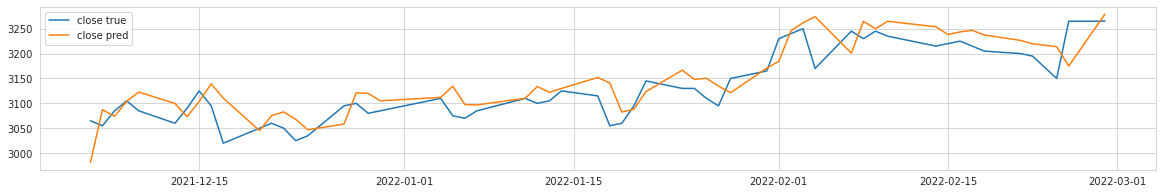

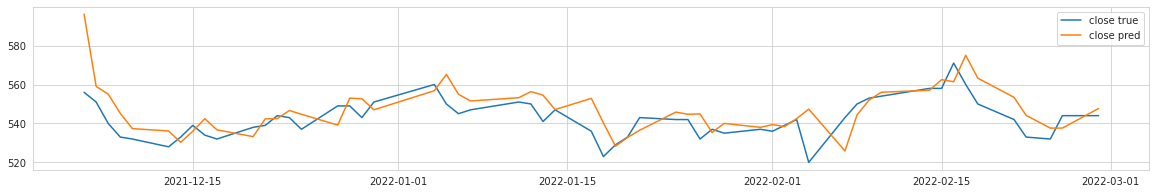

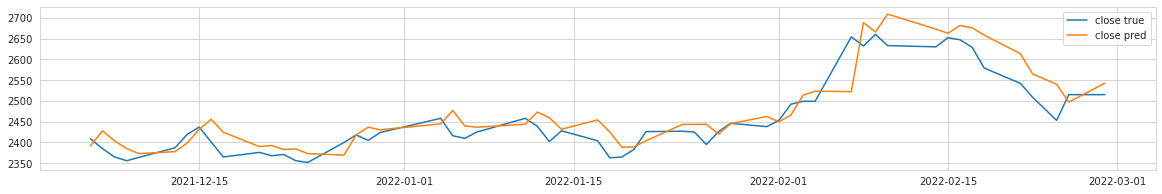

In [41]:
import matplotlib.pyplot as plt

for sc in data.test.SecuritiesCode.unique()[:3]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

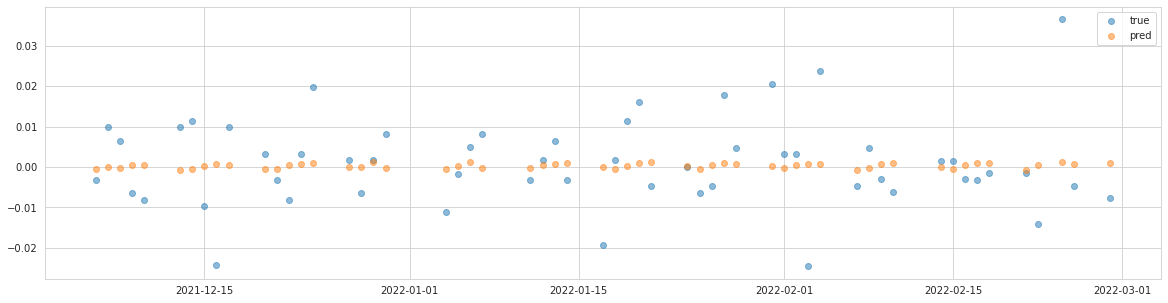

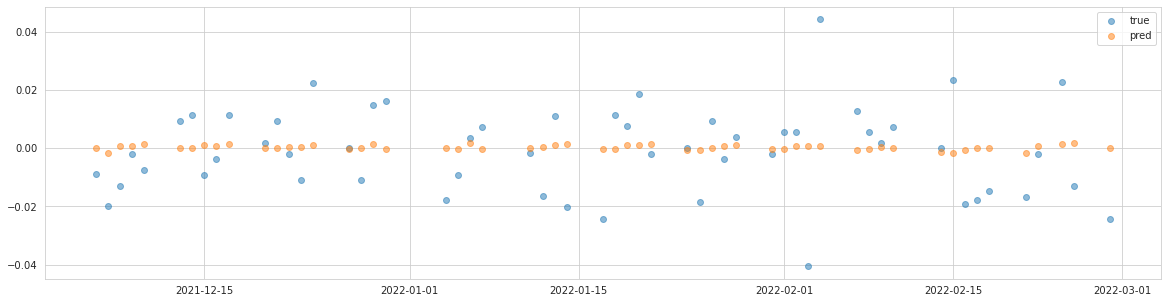

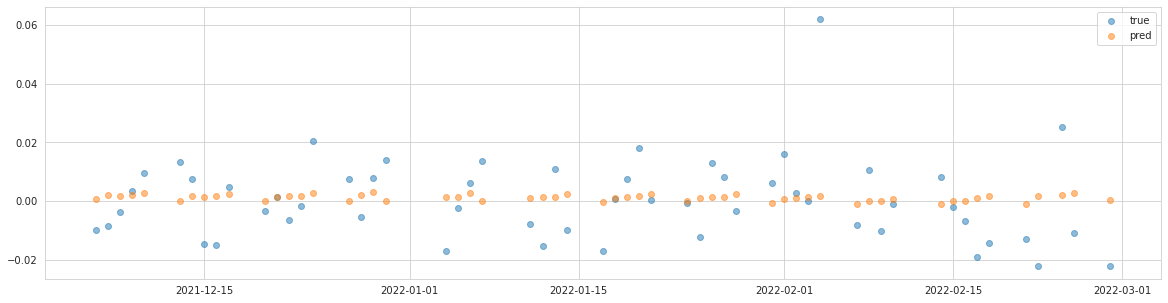

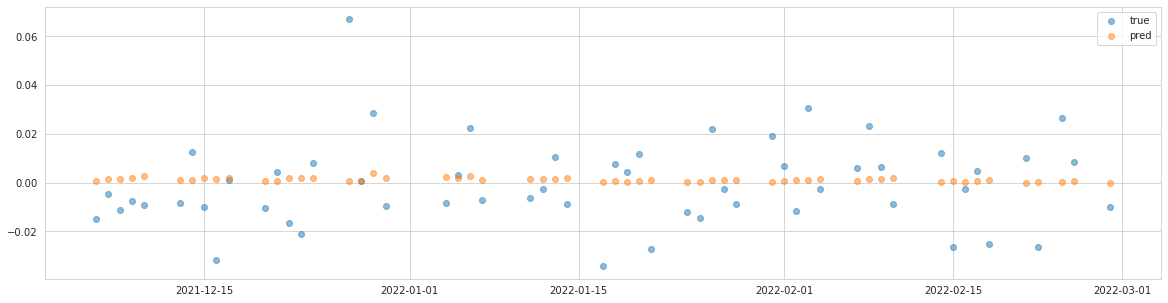

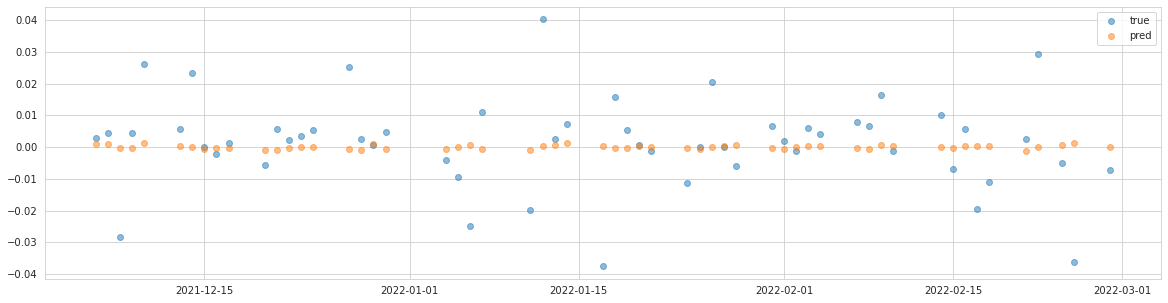

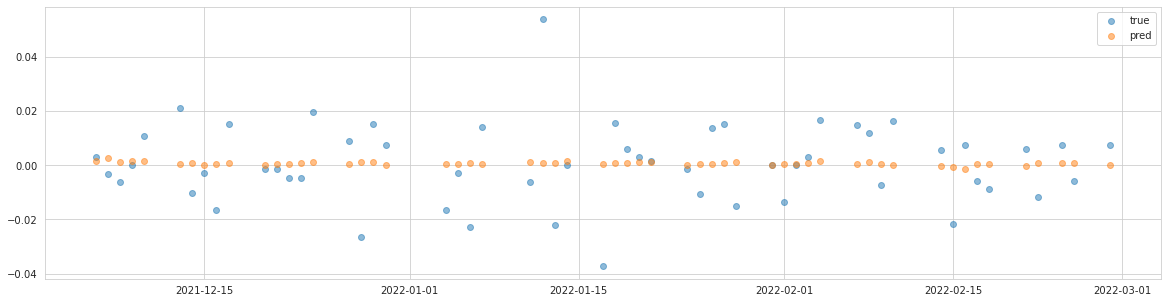

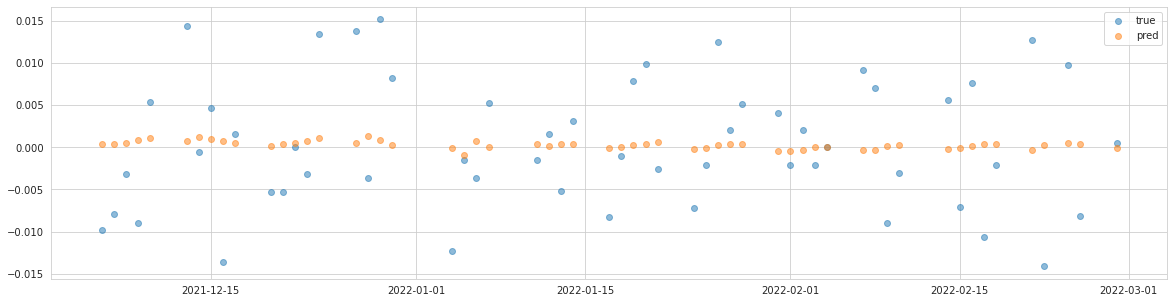

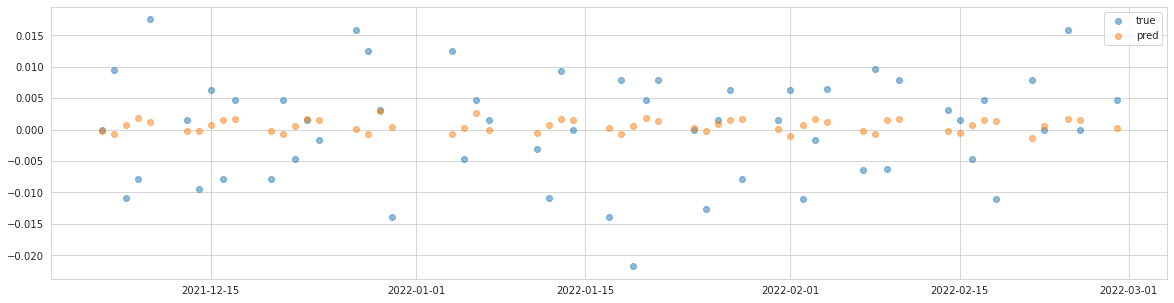

In [42]:
import matplotlib.pyplot as plt

recreated_target_is_valid = data.test.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (data.test.authentic == True) & vt

for sc in data.test.SecuritiesCode.unique()[:8]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df_pred.Date, df_pred.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df_pred.Date, df_pred.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [46]:
from utilities.evaluation import calc_spread_return_sharpe

data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["Target"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(data.test.loc[vt]), data.test.loc[data.test.Rank < 200].Target.sum() - data.test.loc[data.test.Rank >= 1800].Target.sum()

(5.434704919895069, 787.8921722685847)

In [47]:
data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(data.test.loc[vt]), data.test.loc[data.test.Rank < 200].Target.sum() - data.test.loc[data.test.Rank >= 1800].Target.sum()

(0.07695364463972626, 5.280778558776923)

#### Experiments

torch.Size([64, 150, 62])


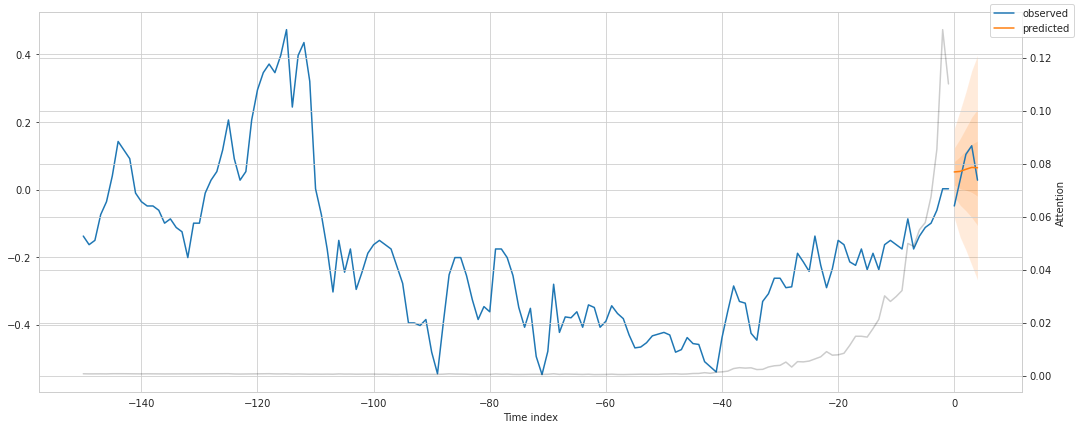

In [53]:
for X, (y, _) in val_dl:
    out = model.forward(X)
    print(X['encoder_cont'].shape)
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    interpretation = model.interpret_output(out, reduction='sum')
    # model.plot_interpretation(interpretation)
    model.plot_prediction(X, out, idx=2, ax=ax)
    break

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x162 with 1 Axes>,
 'encoder_variables': <Figure size 504x1296 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

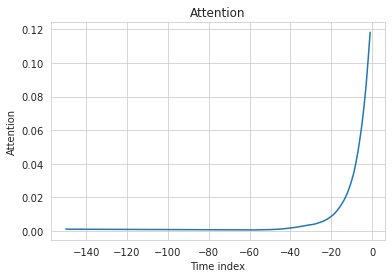

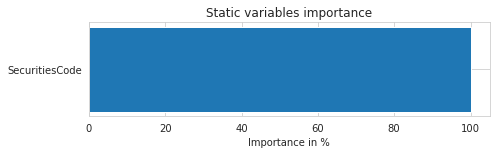

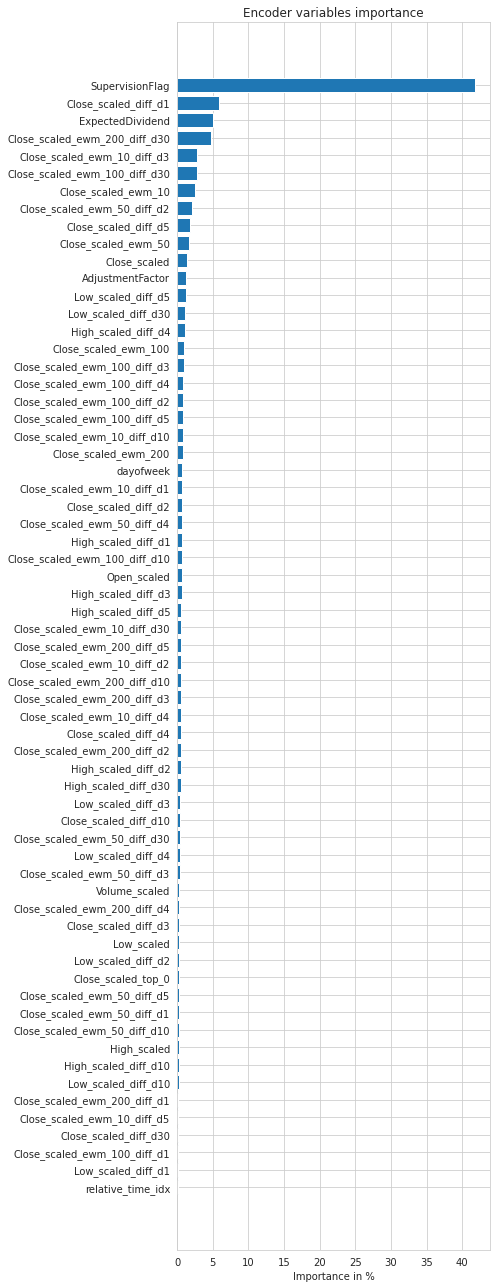

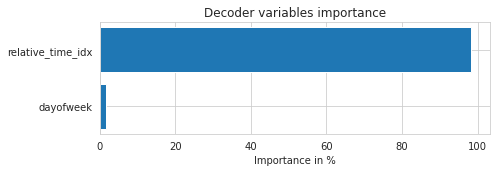

In [51]:
model.plot_interpretation(interpretation)

In [ ]:
model.plot_interpretation()